In [1]:
import datetime as dt
from loguru import logger

import warnings
import datetime as dt
import polars as pl
from pathlib import Path
from loguru import logger

from model import XGBoostModel, GeneticAlgorithm, fitness_function_wrapper
from pipeline import Preprocess
from model import ModelHandler

In [2]:
train_start = 2007
date_col = 'tdq'
target_col = 'fperf'
val_train_window = 12
val_eval_window = 2
last_trade_date = None

In [3]:
def find_last_trading_date():
    """
    Find last trading date, which will be used for stock selection.

    Returns
    -------
    dt.datime
        Trading date.
    """

    today = dt.datetime.today()
    trade_dates = [
        dt.datetime(today.year, 3, 1),
        dt.datetime(today.year, 6, 1),
        dt.datetime(today.year, 9, 1),
        dt.datetime(today.year, 12, 1),
    ]
    past_dates = [date for date in trade_dates if date <= today]

    if past_dates:
        return max(past_dates)
    else:
        return None

last_trade_date = find_last_trading_date()
last_trade_date

datetime.datetime(2024, 9, 1, 0, 0)

In [4]:
data = pl.read_csv("../data/1_work_data/processed/proc_2024-10-17.csv", try_parse_dates=True)
data.head()

datadate,rdq,tdq,tic,sector,val_purch,val_sales,n_purch,n_sales,rsi_14d,rsi_30d,rsi_60d,vol_m,vol_q,vol_y,momentum_mom,momentum_qoq,momentum_yoy,price_mom,price_qoq,price_yoy,ni_qoq,ni_yoy,ni_2y,ltq_qoq,ltq_yoy,ltq_2y,dlttq_yoy,rev_qoq,rev_yoy,gpm,gpm_qoq,gpm_yoy,roa,roa_qoq,roa_yoy,roe,roe_qoq,roe_yoy,fcf_yoy,cfm,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,eps_qoq,eps_yoy,pe,pe_qoq,pe_yoy,ev_ebitda,ev_eb_qoq,ev_eb_yoy,ltcr_yoy,itr,rtr,atr,fperf,adj_fperf
date,date,date,str,str,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
2007-01-31,2007-02-15,2007-03-01,"""A""","""Health Care""",0.0,8.598,0,1,37.080402,42.592688,46.374228,0.014809,0.012043,0.01791,-6.63701,-7.1022,-1.324112,-0.0175,-0.018727,-0.126667,0.006711,-0.946733,0.456311,-0.0469,-0.080125,0.045535,0.0,-0.036145,0.096829,0.578125,-0.011905,0.034773,0.088037,-0.799034,-0.786032,0.17528,-0.806646,-0.758874,1.314607,0.072656,-0.033049,-0.06119,0.051933,0.026403,0.115807,-0.804733,-0.776129,14.209289,4.036292,2.825606,14.053467,-0.106851,-0.424184,1.314607,2.007843,1.87821,0.1758,1,1
2007-04-30,2007-05-14,2007-06-01,"""A""","""Health Care""",0.0,2.695,0,3,62.343397,62.077772,58.732066,0.016561,0.013553,0.017389,0.517117,2.392662,0.463493,0.052226,0.241648,0.097162,-0.18,0.069565,0.294737,0.054299,-0.064022,0.096793,0.0,0.03125,0.065375,0.590909,0.022113,0.058001,0.089666,0.018496,-0.764364,0.18256,0.041531,-0.756945,0.078838,0.228788,-0.048932,-0.09261,0.072623,0.035449,0.106275,0.035601,-0.771817,16.705873,0.175701,3.789035,15.689363,0.116405,-0.275697,0.078838,2.033898,1.900648,0.182371,0,0
2007-07-31,2007-08-14,2007-09-01,"""A""","""Health Care""",0.0,5.747,0,2,52.575103,48.65697,49.886609,0.032772,0.021062,0.01607,2.010229,1.795475,1.064454,-0.057483,-0.051342,0.1375,0.504065,-0.185022,0.778846,0.002146,-0.051054,0.097532,0.0,0.040909,0.108959,0.590247,-0.00112,-0.005011,0.084854,-0.053667,-0.789586,0.184611,0.011234,-0.780068,27.0,0.128093,-0.13529,-0.202801,0.094405,0.044192,0.10037,-0.041947,-0.798223,16.580932,-0.007479,4.723257,14.783464,-0.05774,-0.142223,27.0,2.075529,1.887363,0.192074,0,1
2007-10-31,2007-11-15,2007-12-01,"""A""","""Health Care""",0.0,2.75,0,2,59.704889,54.609299,52.512775,0.026217,0.017897,0.016334,4.424257,7.683146,3.097014,0.026594,0.046184,0.180712,-0.027027,0.208054,6.2,0.156317,0.16442,0.638847,0.391333,0.052402,0.088855,0.577455,-0.021673,-0.01305,0.087529,0.031532,-0.800194,0.197279,0.068621,-0.782379,-0.057743,0.275242,-0.142226,-0.198205,0.313484,0.135903,0.357259,0.098079,-0.787262,15.693153,-0.053542,4.562228,14.923904,0.0095,-0.051532,-0.322767,2.1959,1.96334,0.198381,0,0
2008-01-31,2008-02-13,2008-03-01,"""A""","""Health Care""",0.0,3.418,0,2,34.6395,38.84194,42.496746,0.018267,0.018484,0.017808,1.027843,1.878156,0.510655,-0.104447,-0.190854,-0.026399,-0.333333,-0.2,-0.957386,-0.00787,0.212104,0.114984,-0.582667,-0.036653,0.088281,0.583632,0.010698,0.009526,0.080996,-0.074634,-0.079976,0.191617,-0.028701,0.093202,-1.535714,0.002872,-0.306119,-0.280077,0.396995,0.168878,-0.597549,-0.041843,0.043885,13.252579,-0.155518,-0.06733,10.717445,-0.28186,-0.237381,-2.28366,2.115414,1.906913,0.185573,1,1


In [5]:
data = data.filter((pl.col('tdq') < last_trade_date))
data = data.filter(~pl.all_horizontal(pl.col(target_col).is_null()))

data = data.to_dummies(columns=['sector'])

# filter cols
aux_cols = ['datadate', 'rdq', 'sector', 'adj_fperf']
data = data.select([c for c in data.columns if c not in aux_cols])
data.head()

tdq,tic,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities,val_purch,val_sales,n_purch,n_sales,rsi_14d,rsi_30d,rsi_60d,vol_m,vol_q,vol_y,momentum_mom,momentum_qoq,momentum_yoy,price_mom,price_qoq,price_yoy,ni_qoq,ni_yoy,ni_2y,ltq_qoq,ltq_yoy,ltq_2y,dlttq_yoy,rev_qoq,rev_yoy,gpm,gpm_qoq,gpm_yoy,roa,roa_qoq,roa_yoy,roe,roe_qoq,roe_yoy,fcf_yoy,cfm,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,eps_qoq,eps_yoy,pe,pe_qoq,pe_yoy,ev_ebitda,ev_eb_qoq,ev_eb_yoy,ltcr_yoy,itr,rtr,atr,fperf
date,str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2007-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0.0,8.598,0,1,37.080402,42.592688,46.374228,0.014809,0.012043,0.01791,-6.63701,-7.1022,-1.324112,-0.0175,-0.018727,-0.126667,0.006711,-0.946733,0.456311,-0.0469,-0.080125,0.045535,0.0,-0.036145,0.096829,0.578125,-0.011905,0.034773,0.088037,-0.799034,-0.786032,0.17528,-0.806646,-0.758874,1.314607,0.072656,-0.033049,-0.06119,0.051933,0.026403,0.115807,-0.804733,-0.776129,14.209289,4.036292,2.825606,14.053467,-0.106851,-0.424184,1.314607,2.007843,1.87821,0.1758,1
2007-06-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0.0,2.695,0,3,62.343397,62.077772,58.732066,0.016561,0.013553,0.017389,0.517117,2.392662,0.463493,0.052226,0.241648,0.097162,-0.18,0.069565,0.294737,0.054299,-0.064022,0.096793,0.0,0.03125,0.065375,0.590909,0.022113,0.058001,0.089666,0.018496,-0.764364,0.18256,0.041531,-0.756945,0.078838,0.228788,-0.048932,-0.09261,0.072623,0.035449,0.106275,0.035601,-0.771817,16.705873,0.175701,3.789035,15.689363,0.116405,-0.275697,0.078838,2.033898,1.900648,0.182371,0
2007-09-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0.0,5.747,0,2,52.575103,48.65697,49.886609,0.032772,0.021062,0.01607,2.010229,1.795475,1.064454,-0.057483,-0.051342,0.1375,0.504065,-0.185022,0.778846,0.002146,-0.051054,0.097532,0.0,0.040909,0.108959,0.590247,-0.00112,-0.005011,0.084854,-0.053667,-0.789586,0.184611,0.011234,-0.780068,27.0,0.128093,-0.13529,-0.202801,0.094405,0.044192,0.10037,-0.041947,-0.798223,16.580932,-0.007479,4.723257,14.783464,-0.05774,-0.142223,27.0,2.075529,1.887363,0.192074,0
2007-12-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0.0,2.75,0,2,59.704889,54.609299,52.512775,0.026217,0.017897,0.016334,4.424257,7.683146,3.097014,0.026594,0.046184,0.180712,-0.027027,0.208054,6.2,0.156317,0.16442,0.638847,0.391333,0.052402,0.088855,0.577455,-0.021673,-0.01305,0.087529,0.031532,-0.800194,0.197279,0.068621,-0.782379,-0.057743,0.275242,-0.142226,-0.198205,0.313484,0.135903,0.357259,0.098079,-0.787262,15.693153,-0.053542,4.562228,14.923904,0.0095,-0.051532,-0.322767,2.1959,1.96334,0.198381,0
2008-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0.0,3.418,0,2,34.6395,38.84194,42.496746,0.018267,0.018484,0.017808,1.027843,1.878156,0.510655,-0.104447,-0.190854,-0.026399,-0.333333,-0.2,-0.957386,-0.00787,0.212104,0.114984,-0.582667,-0.036653,0.088281,0.583632,0.010698,0.009526,0.080996,-0.074634,-0.079976,0.191617,-0.028701,0.093202,-1.535714,0.002872,-0.306119,-0.280077,0.396995,0.168878,-0.597549,-0.041843,0.043885,13.252579,-0.155518,-0.06733,10.717445,-0.28186,-0.237381,-2.28366,2.115414,1.906913,0.185573,1


In [6]:
train = data.filter(
    (pl.col('tdq').dt.year() > 2007) &
    (pl.col('tdq').dt.year() <= 2020)
)
val = data.filter(
    (pl.col('tdq').dt.year() > 2020) &
    (pl.col('tdq').dt.year() < 2023)
)
scale = int(
    len(train.filter(pl.col(target_col) == 0)) /
    len(train.filter(pl.col(target_col) == 1))
)

print(f"Scale of training data (pos/neg): {scale}")

X_train = train.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_train = train.select(target_col).to_pandas().values.ravel()
X_val = val.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_val = val.select(target_col).to_pandas().values.ravel()

X_train

Scale of training data (pos/neg): 7


,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,...,pe,pe_qoq,pe_yoy,ev_ebitda,ev_eb_qoq,ev_eb_yoy,ltcr_yoy,itr,rtr,atr
0,0,0,0,0,0,1,0,0,0,0,...,13.252579,-0.155518,-0.067330,10.717445,-0.281860,-0.237381,-2.283660,2.115414,1.906913,0.185573
1,0,0,0,0,0,1,0,0,0,0,...,14.637105,0.104472,-0.123835,11.869896,0.107530,-0.243443,1.671284,2.160237,1.919578,0.192427
2,0,0,0,0,0,1,0,0,0,0,...,13.847247,-0.053963,-0.164869,10.402216,-0.123647,-0.296361,1.306055,2.142433,1.860825,0.189813
3,0,0,0,0,0,1,0,0,0,0,...,6.235459,-0.549697,-0.602664,7.573268,-0.271956,-0.492541,-0.414559,2.243939,1.934683,0.197757
4,0,0,0,0,0,1,0,0,0,0,...,5.377385,-0.137612,-0.594239,7.082598,-0.064790,-0.339152,0.835314,1.792467,1.665714,0.159737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31126,0,0,0,0,0,1,0,0,0,0,...,39.719629,-0.104275,0.013850,26.864585,-0.097343,0.108792,-0.080856,1.114316,1.565217,0.142331
31127,0,0,0,0,0,1,0,0,0,0,...,42.792320,0.077360,0.310742,29.183695,0.086326,0.202001,0.079693,1.175149,1.582231,0.146733
31128,0,0,0,0,0,1,0,0,0,0,...,41.132749,-0.038782,0.169510,28.539187,-0.022085,0.137147,0.133447,1.061224,1.495856,0.132969
31129,0,0,0,0,0,1,0,0,0,0,...,47.913486,0.164850,0.080507,32.336830,0.133068,0.086525,0.234147,1.010114,1.588507,0.125869


In [7]:
float(
    len(train.filter(pl.col(target_col) == 1)) /
    len(train)
)

0.1190453245960618

In [14]:
model = XGBoostModel(scale=scale)
model.train(X_train, y_train)
perf = model.evaluate(X_val, y_val)['roc_auc']
perf

0.6550143217615132

In [15]:
# pr auc analysis
baseline = float(
    len(train.filter(pl.col(target_col) == 1)) /
    len(train)
)

pr_auc = model.evaluate(X_val, y_val)['pr_auc']
pr_auc

print(f"Baseline {baseline}, PR-AUC = {pr_auc}")

Baseline 0.1190453245960618, PR-AUC = 0.17859563592888864


In [9]:
model.get_importance("gain")

[('vol_q', 963.2418823242188),
 ('vol_y', 332.96099853515625),
 ('vol_m', 190.84413146972656),
 ('sector_Utilities', 86.84618377685547),
 ('momentum_mom', 80.96171569824219),
 ('price_mom', 75.06919860839844),
 ('atr', 73.59374237060547),
 ('sector_Information Technology', 72.53203582763672),
 ('price_yoy', 71.70513153076172),
 ('ltda_yoy', 71.62337493896484),
 ('sector_Real Estate', 71.37299346923828),
 ('rsi_60d', 69.20642852783203),
 ('qr_yoy', 63.64753723144531),
 ('itr', 62.44826126098633),
 ('rsi_14d', 62.182533264160156),
 ('roa_yoy', 61.960105895996094),
 ('ltq_2y', 61.94793701171875),
 ('ev_ebitda', 60.95396041870117),
 ('cr_yoy', 60.09981918334961),
 ('pe', 57.459388732910156),
 ('rsi_30d', 55.54800033569336),
 ('momentum_yoy', 54.578033447265625),
 ('val_sales', 54.148624420166016),
 ('ni_qoq', 53.1922607421875),
 ('dlttq_yoy', 53.116119384765625),
 ('der_yoy', 52.17774200439453),
 ('rev_qoq', 51.674583435058594),
 ('roa', 51.06098175048828),
 ('price_qoq', 49.33680725097656

In [10]:
model.get_importance("weight")

[('vol_y', 70.0),
 ('momentum_mom', 57.0),
 ('momentum_qoq', 36.0),
 ('vol_q', 35.0),
 ('momentum_yoy', 35.0),
 ('price_mom', 31.0),
 ('atr', 25.0),
 ('price_yoy', 21.0),
 ('rsi_30d', 17.0),
 ('roa', 16.0),
 ('ltda_yoy', 16.0),
 ('vol_m', 14.0),
 ('rev_yoy', 14.0),
 ('rtr', 14.0),
 ('ltq_yoy', 13.0),
 ('ev_ebitda', 13.0),
 ('itr', 13.0),
 ('ltq_qoq', 12.0),
 ('gpm', 12.0),
 ('sector_Utilities', 11.0),
 ('cr_yoy', 11.0),
 ('qr_yoy', 11.0),
 ('pe', 11.0),
 ('rev_qoq', 10.0),
 ('der_yoy', 10.0),
 ('val_sales', 9.0),
 ('ltq_2y', 9.0),
 ('gpm_qoq', 9.0),
 ('ni_2y', 8.0),
 ('roa_yoy', 8.0),
 ('cfm', 8.0),
 ('pe_qoq', 8.0),
 ('pe_yoy', 8.0),
 ('sector_Information Technology', 7.0),
 ('n_sales', 7.0),
 ('gpm_yoy', 7.0),
 ('roe', 6.0),
 ('dr_yoy', 6.0),
 ('eps_qoq', 6.0),
 ('ev_eb_yoy', 6.0),
 ('rsi_14d', 5.0),
 ('ni_qoq', 5.0),
 ('dlttq_yoy', 5.0),
 ('roe_qoq', 5.0),
 ('fcf_yoy', 5.0),
 ('ltcr_yoy', 5.0),
 ('price_qoq', 4.0),
 ('sector_Real Estate', 3.0),
 ('roa_qoq', 3.0),
 ('sector_Health Ca

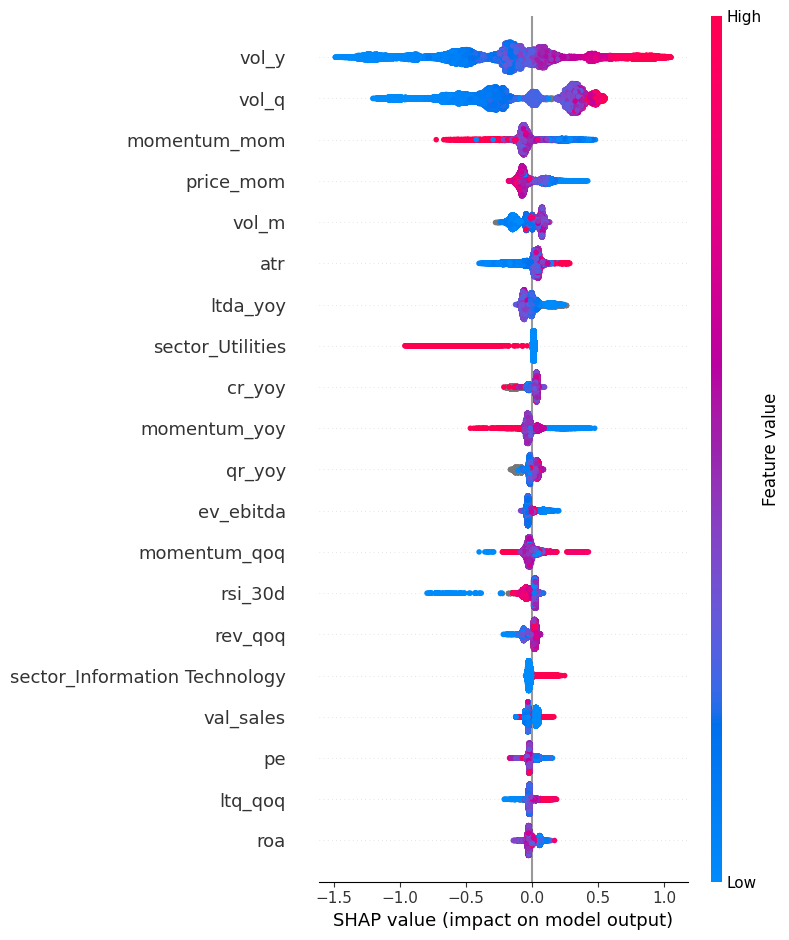

In [11]:
import shap

explainer = shap.TreeExplainer(model.model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=20)

In [12]:
import numpy as np
import pandas as pd

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean Abs SHAP Value': mean_abs_shap
})
shap_df

,Feature,Mean Abs SHAP Value
0,sector_Communication Services,0.000000
1,sector_Consumer Discretionary,0.000000
2,sector_Consumer Staples,0.000000
3,sector_Energy,0.000000
4,sector_Financials,0.000000
...,...,...
59,ev_eb_yoy,0.011028
60,ltcr_yoy,0.002710
61,itr,0.012881
62,rtr,0.023506
